<a href="https://colab.research.google.com/github/JINDOT/Data_Analysis_/blob/main/Online_Retail_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Onlie Retail 를 이용한 RFM 분석

## 필요 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

# # Colormap 커스텀
# from matplotlib.colors import ListedColormap
# from matplotlib.colors import LinearSegmentedColormap
# colors = ["white", "#7FFF00", "#32CD32", "#00FA9A", "#00FF7F"]
# MediumSpringGreen = LinearSegmentedColormap.from_list("custom_cmap", colors)

In [2]:
# 전처리를 해야하기 때문에 raw 라고 일단 하자.
raw = pd.read_csv('/content/drive/MyDrive/csv/online_retail.csv')

In [3]:
raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
raw.shape

(541909, 8)

## 데이터 전처리

### 유효 데이터 추출

In [5]:
# 전 작업이랑 동일
# CustomerID 존재, Quantity, UnitPrice 가 0보다 큰 데이터만 사용
raw_valid = raw[(raw['CustomerID'].notnull()) & (raw['Quantity'] > 0) & (raw['UnitPrice'] > 0)]
raw_valid.shape

(397884, 8)

### 총 구매 금액

In [6]:
# TotalPrice
raw_valid['TotalPrice'] = raw_valid['Quantity'] * raw_valid['UnitPrice']
raw_valid.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


In [7]:
raw_valid.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453,22.397000
std,179.331775,22.097877,1713.141560,309.071041
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


TotalPrice 를 자세히 보면 최대값이 평균값 보다 유독 큰 금액으로 나오는 것이 보인다.(= 이상치)

### 이상치 제거

In [8]:
# 해당 주문건 확인
raw_valid[raw_valid['TotalPrice'] > 160000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6


총 주문 금액 160,000 이상인 주문건을 검색했을 때, 16446 고객의 주문건이 검색된다. Quantity(주문량)을 보았을 때 굉장히 많은 것을 볼 수 있다.

In [9]:
# 해당 주문건 고객 확인
raw_valid[raw_valid['CustomerID'] == 16446]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,1.25
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60


다른 품목 또한 비슷한 양으로 주문했다면 이상치가 아니겠지만 현재로서는 주문오류로 볼 수 있다.

In [10]:
# 이상치 제거
raw_valid = raw_valid[raw_valid['TotalPrice'] < 160000].copy()
raw_valid.shape

(397883, 9)

이와 같이 실제 비지니스에서도 이상치를 무조건적으로 제거하기 보다는 여러 데이터를 확인해보고 제거해주어야 한다.

예를 들어 한 품목에 대해서 대량 주문 계약이었던 상황도 고려해보아야한다.

### 중복 데이터
> 중복 데이터는 여러 이유로 발생한다. 네트워크 통신 문제나 쇼핑몰 UI 구성 등 다양하다.

> 예를 들어 주문을 하고 새로고침 을 실행했을 때, 주문 트랜젝션이 다시 들어가는 이슈가 발생할 수 있다.

In [11]:
# 중복 데이터 확인
# keep='first', 'last', False
raw_valid[raw_valid.duplicated(keep='first')].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,2.95
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95


In [12]:
raw_valid[raw_valid.duplicated(keep='last')].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,2.95
548,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95


In [13]:
raw_valid[raw_valid.duplicated(keep=False)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,2.95


In [14]:
# 중복 데이터 제거
df = raw_valid.drop_duplicates().copy()
df.shape

(392691, 9)

이 작업을 마지막으로 전처리가 끝났다.

## RFM

>***Rencency*** : 얼마나 최근에 구매했는가

>***Frequency*** : 얼마나 자주 구매했는가

>***Monetary*** : 얼마나 많은 금액을 지출했는가

즉, **가장 최근에 구매할수록, 자주 구매할수록, 많은 금액을 결제할수록 충성고객일 확률이 높다.**이렇게 고객들을 알고 그에 맞춰 충성고객일수록 더욱 많은 관심을 가질 수 있도록 그리고 아닌 고객일수록 좀 더 자회사 제품에 관심을 가질 수 있도록 만들 수 있다.


>***RFM 모형***
* Scoring 기법: RFM의 요인을 각각 5등급으로 등간격으로 분류하는 방법이다.
* 현재 개발된 RFM 모형은 크게 4가지로 분류 할 수 있다. 무조건적인 모델은 아니지만 참고할만 한 4가지 방법이다.
    * 모델1. RFM 각 요소의 20% rule의 적용
    * 모델2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
    * 모델3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
    * 모델4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류
* Data Mining 기법을 이용한 모형
* 회귀분석
* 선형 회귀 분석을 이용한 모형: 고객의 구매 최근성, 구매 빈도, 구매 금액 등 고객의 수익 기여도를 나타내는 세가지 지표들의 선형결합으로 세가지 지표들을 점수화 한다.
* 다중 회귀 분석을 이용한 모형: 각 고객의 구매 행동을 나타내는 R,F,M의 변수들을 독립변수로하고 고객의 미래 구매 행동을 예측하는 기법.
* 신경망을 적용한 모형: 로지스틱 회귀 모형을 보완하는 차원에서 연구.
* 확률적 RFM모형:Colombo와 Weina의 확률적인 RFM모형은 과거의 고객의 응답 이력으로 고객의 미래 응답을 예측하는 행동모델이다.

### 전체 주문에서 최근 주문일 조회

In [15]:
# InvoiceDate 날짜 형식 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [16]:
# Recency
# 해당 주문에서 가장 최근 구매가 일어난 시간 조회
# 영업 기준 가장 마지막 날
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [17]:
# 최근 거래 기준일을 만들기 위해 timedelta로 날짜를 더해줌
# 최소값 = 1
last_timestemp = df['InvoiceDate'].max() + dt.timedelta(days=1)
last_timestemp

Timestamp('2011-12-10 12:50:00')

### 고객별 Recency, Frequency, Monetary 값 얻기

In [18]:
# RFM
# 데이터 프레임을 CustomerID 별로 그룹화 후 집계함수를 통한 rfm 생성
# 'InvoiceDate' : lambda x : (last_timestemp - x.max()).days
# : 각 고객의 거래 날짜 시리즈 'x'에 대해 마지막 거래 날짜 'x.max()'를 찾아 빼주고 일단위로 변
rfm = df.groupby('CustomerID').agg({'InvoiceDate' : lambda x : (last_timestemp - x.max()).days,
                                    'InvoiceNo' : 'count',
                                    'TotalPrice' : 'sum'})
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [19]:
# RFM columns name 재설정
rfm = rfm.rename(columns={'InvoiceDate' : 'Recency',
                    'InvoiceNo' : 'Frequency',
                    'TotalPrice' : 'MonetaryValue'})
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [20]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.583679,90.523513,2009.852304
std,100.019339,225.507058,8622.507371
min,1.000000,1.000000,2.900000
25%,18.000000,17.000000,306.452500
50%,51.000000,41.000000,668.495000
75%,142.750000,98.000000,1659.132500
max,374.000000,7676.000000,280206.020000


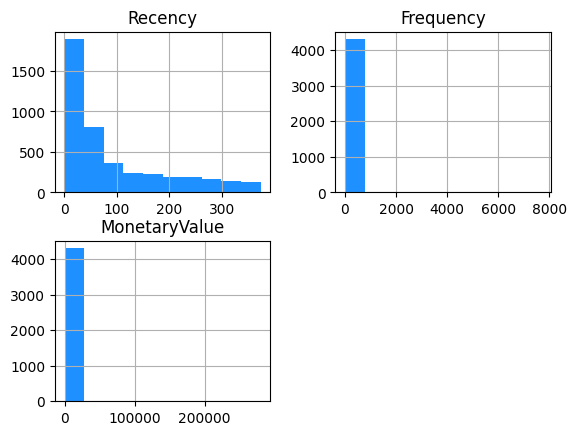

In [22]:
rfm.hist(color='dodgerblue');

### qcut을 이용한 RFM 구하기

**pd.cut()**
> *Equal-length* buckets, 동일한 길이로 나눔.

**pd.qcut()**
> *Equal-size buckets*, 동일한 개수로 나눔.

**RFM 점수 조건**

>**Recency는 최근일 수록** 높은 점수를 갖도록 한다.

>**Frequency, Monetary는 값이 클 수록** 높은 점수를 갖도록 한다.

In [23]:
# r_labels
# 최근일 수록 5점 -1씩 감점
r_labels = list(range(5, 0, -1))

# f_labels
f_labels = list(range(1,6))

# m_labels
m_labels = list(range(1,6))

# cut_size
cut_size = 5

In [24]:
r_qcut = pd.qcut(rfm['Recency'], q=cut_size, labels=r_labels)
f_qcut = pd.qcut(rfm['Frequency'], q=cut_size, labels=f_labels)
m_qcut = pd.qcut(rfm['MonetaryValue'], q=cut_size, labels=m_labels)

In [25]:
 r_qcut.value_counts(1), f_qcut.value_counts(1), m_qcut.value_counts(1)

(Recency
 4    0.204703
 5    0.203550
 1    0.199631
 3    0.197787
 2    0.194329
 Name: proportion, dtype: float64,
 Frequency
 1    0.213693
 4    0.199401
 5    0.198709
 3    0.195251
 2    0.192946
 Name: proportion, dtype: float64,
 MonetaryValue
 1    0.200092
 3    0.200092
 5    0.200092
 2    0.199862
 4    0.199862
 Name: proportion, dtype: float64)

In [26]:
# 변수 설정
# assign : 여러 개의 변수를 한 번에 생성
rfm = rfm.assign(R=r_qcut, F=f_qcut, M=m_qcut)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,19,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2


### RFM Segment & Score
segment : 데이터를 특정 기준에 따라 그룹화 한 것을 의미

In [27]:
# RFM Segment
# R,F,M 점수를 하나로 통합
rfm['RFM_segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,182,4310.00,5,5,5,555
12348.0,75,31,1797.24,2,3,4,234
12349.0,19,73,1757.55,4,4,4,444
12350.0,310,17,334.40,1,2,2,122


In [28]:
# rfm['RFM_Segment'] 점수 합계
rfm['RFM_score'] = rfm[['R','F','M']].astype(int).sum(axis=1)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,182,4310.00,5,5,5,555,15
12348.0,75,31,1797.24,2,3,4,234,9
12349.0,19,73,1757.55,4,4,4,444,12
12350.0,310,17,334.40,1,2,2,122,5


<Axes: xlabel='RFM_segment', ylabel='RFM_score'>

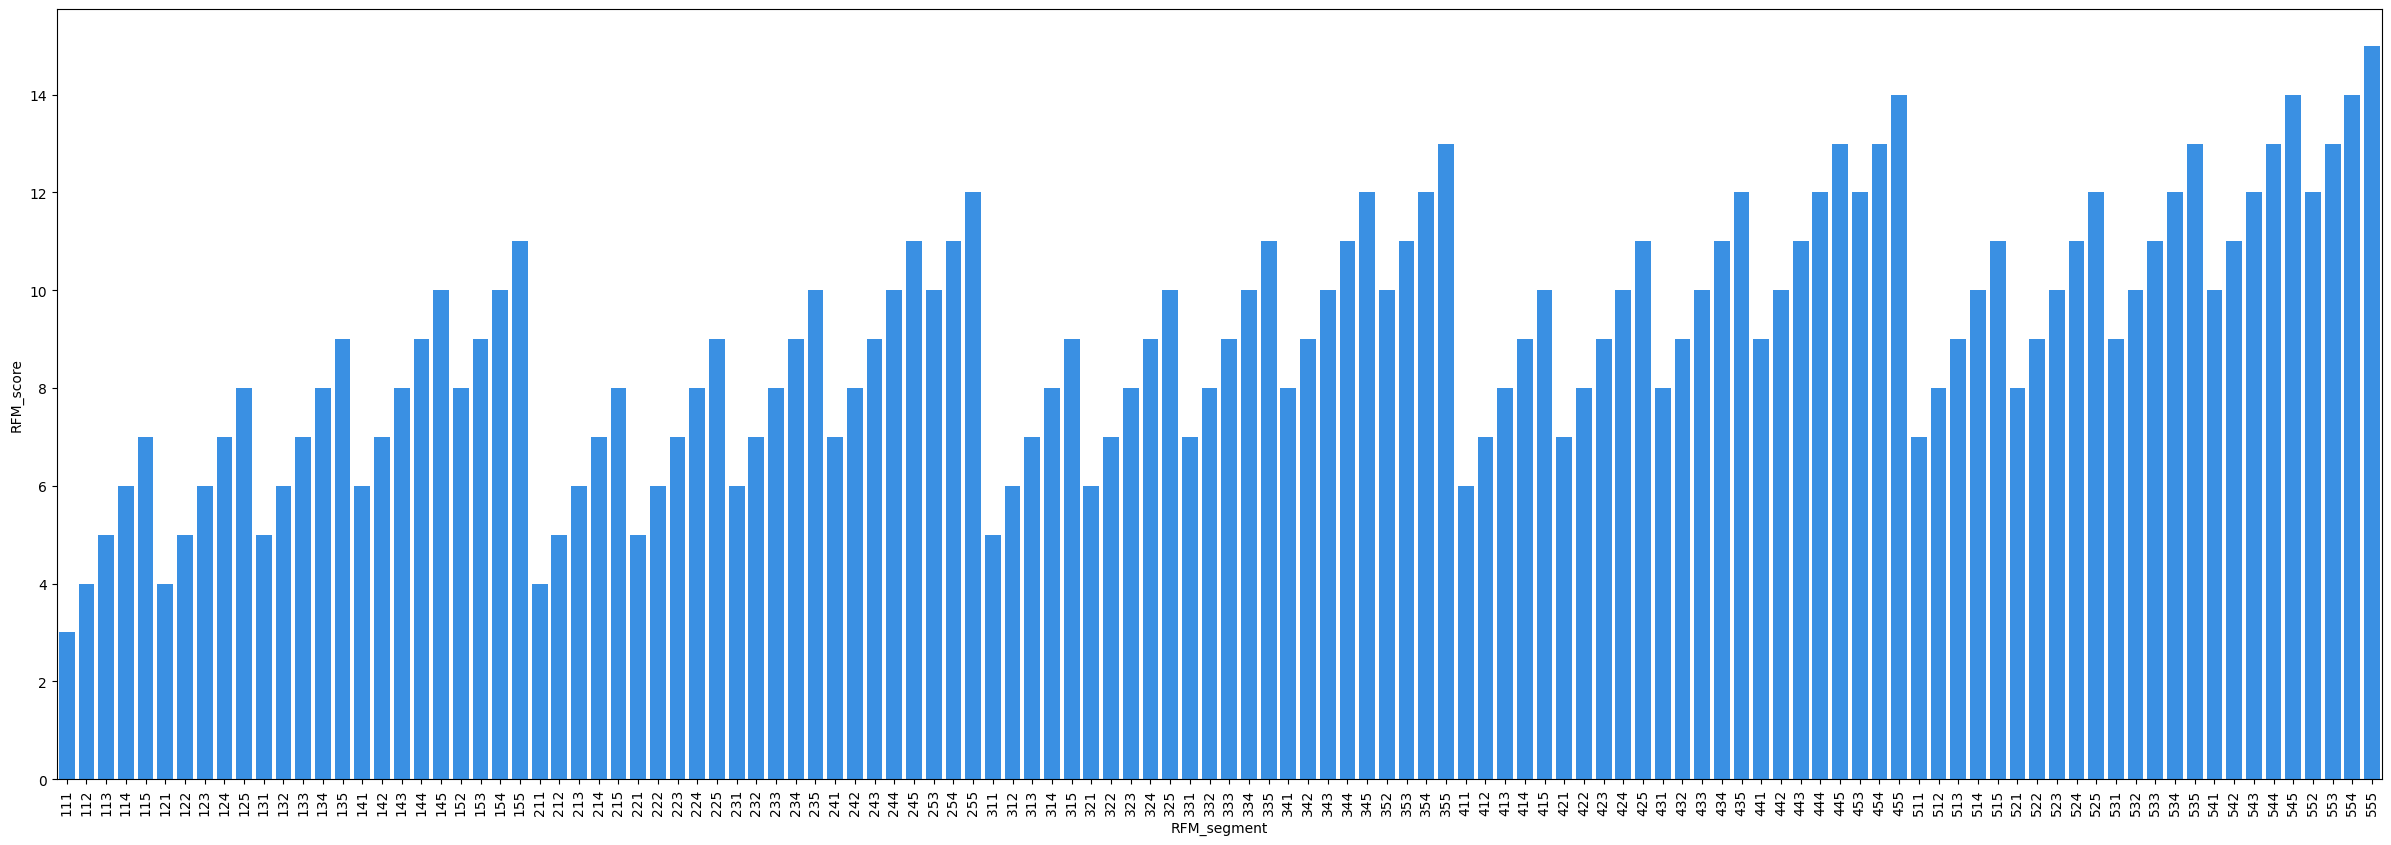

In [31]:
# Segment 와 Score 값에 따른 시각화
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values('RFM_segment'), x='RFM_segment', y='RFM_score', color='dodgerblue')

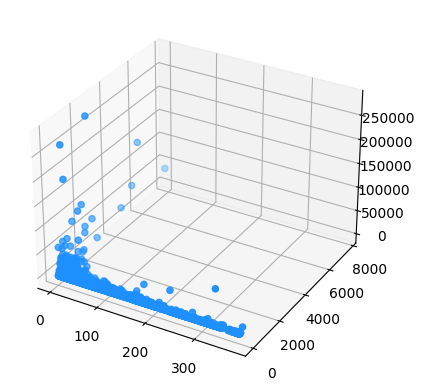

In [32]:
# 3D Projection
# ax.scatter
ax = plt.axes(projection='3d')
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['MonetaryValue'], c='dodgerblue')

한 쪽으로 치우쳐 있는 모습.(이상치 값 존재)

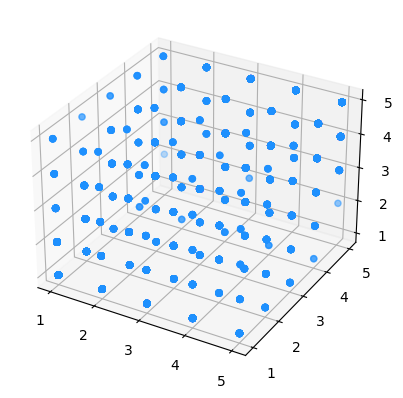

In [33]:
ax = plt.axes(projection='3d')
ax.scatter(rfm['R'], rfm['F'], rfm['M'], c='dodgerblue')

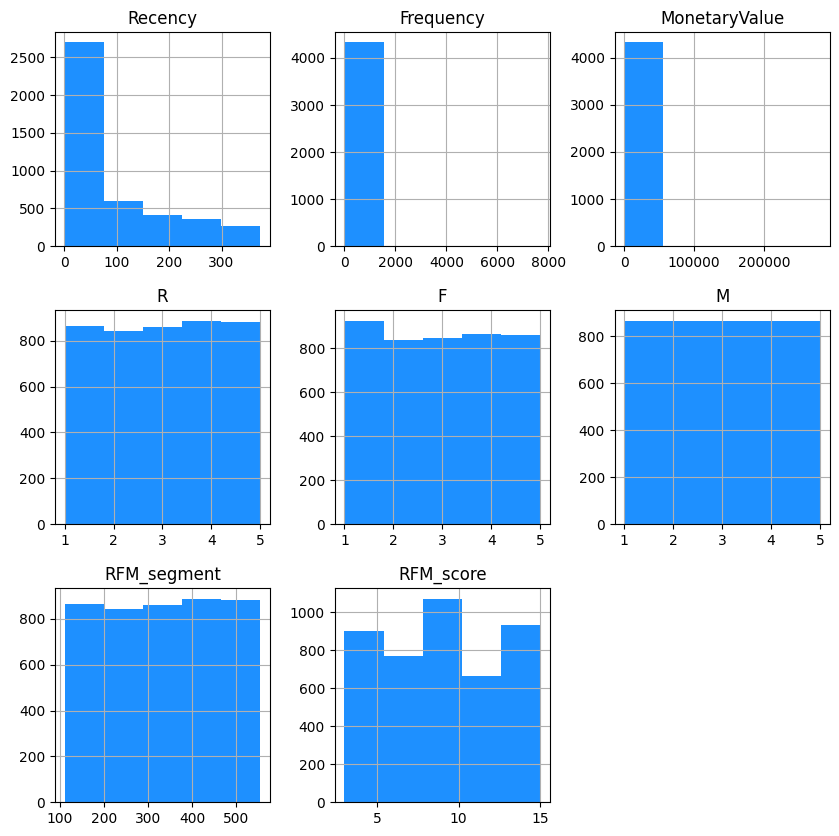

In [34]:
rfm.astype(int).hist(bins=5, figsize=(10,10), color='dodgerblue');

In [35]:
# 각 segment의 평균과 총 지출
# format 함수을 이용하여 소수점 아래는 표기 X
rfm.groupby('RFM_score').agg({'Recency':'mean',
                              'Frequency':'mean',
                              'MonetaryValue':['mean','sum']}).style.background_gradient('Blues').format("{:,.0f}")

Recency Score가 최하점일 경우 구매한지 278일만에 재구매가 이루어졌고, 최고점은 구매한지 5일만에 재구매가 이루어졌다.

Frequency Score가 최하점일 경우 총 7번 구매를 하였고, 최고점일 경우 439번 구매를 하였다.

Monetary Score는 최하점이 총 합계금액 37,309, 최고점은 총 합계금액 3,583,278 이다.

### qcut을 이용한 3단계 고객군

In [36]:
# 3단계(q=3) : silver, gold, platinum
rfm['RFM_class'] = pd.qcut(rfm['RFM_score'], q=3, labels=['silver', 'gold', 'platinum'])
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver
12347.0,2,182,4310.00,5,5,5,555,15,platinum
12348.0,75,31,1797.24,2,3,4,234,9,gold
12349.0,19,73,1757.55,4,4,4,444,12,platinum
12350.0,310,17,334.40,1,2,2,122,5,silver


In [37]:
# RFM_class 별 그룹화
rfm.groupby('RFM_class')['RFM_score'].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,1668.0,5.209832,1.384324,3.0,4.0,5.0,6.0,7.0
gold,1409.0,9.469127,1.114505,8.0,8.0,9.0,10.0,11.0
platinum,1261.0,13.471055,1.124120,12.0,12.0,13.0,14.0,15.0


<Axes: xlabel='RFM_class', ylabel='RFM_score'>

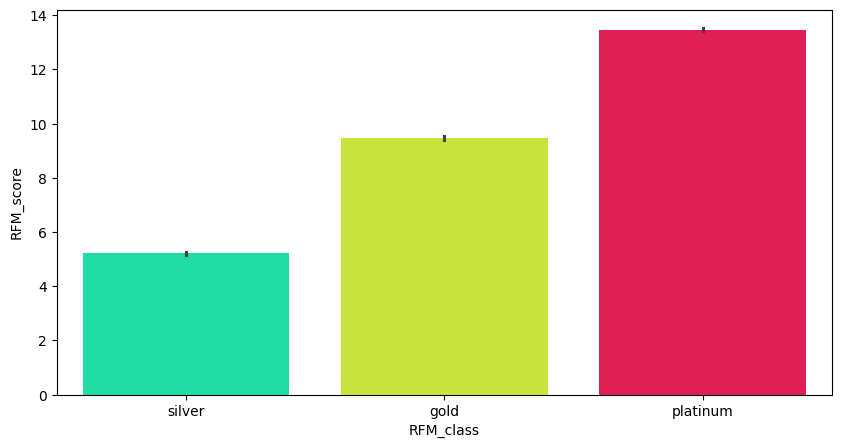

In [54]:
# barplot, RFM_class 별 평균 RFM_score
plt.figure(figsize=(10,5))
sns.barplot(data=rfm, x='RFM_class', y='RFM_score', palette='gist_ncar')

<Axes: xlabel='RFM_class', ylabel='RFM_score'>

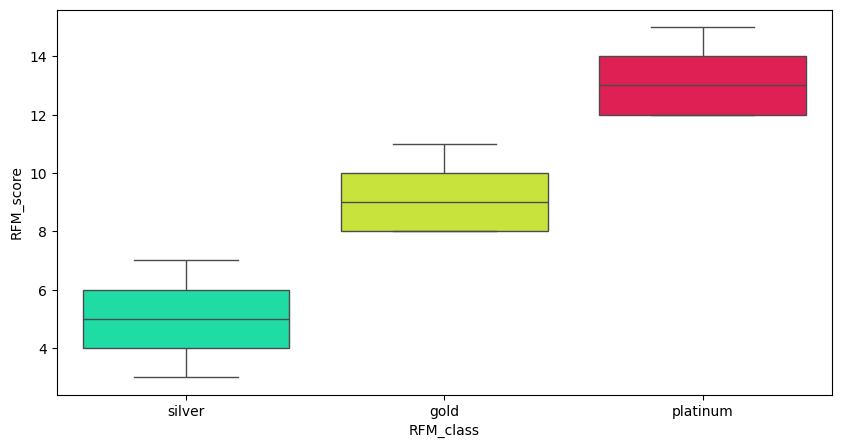

In [46]:
# boxplot, RFM_class 별 평균 RFM_score
plt.figure(figsize=(10,5))
sns.boxplot(data=rfm, x='RFM_class', y='RFM_score', palette='gist_ncar')

<Axes: xlabel='R', ylabel='RFM_score'>

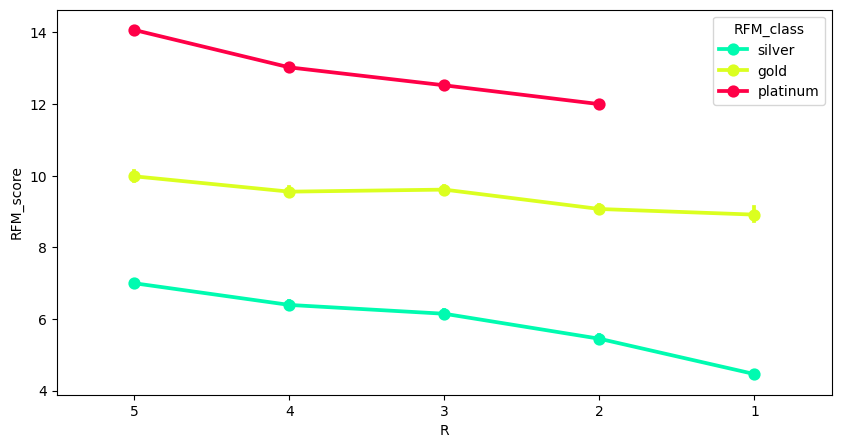

In [47]:
# pointplot, Recency부분 RFM_score
plt.figure(figsize=(10,5))
sns.pointplot(data=rfm, x='R', hue='RFM_class', y='RFM_score', palette='gist_ncar')

<Axes: xlabel='F', ylabel='RFM_score'>

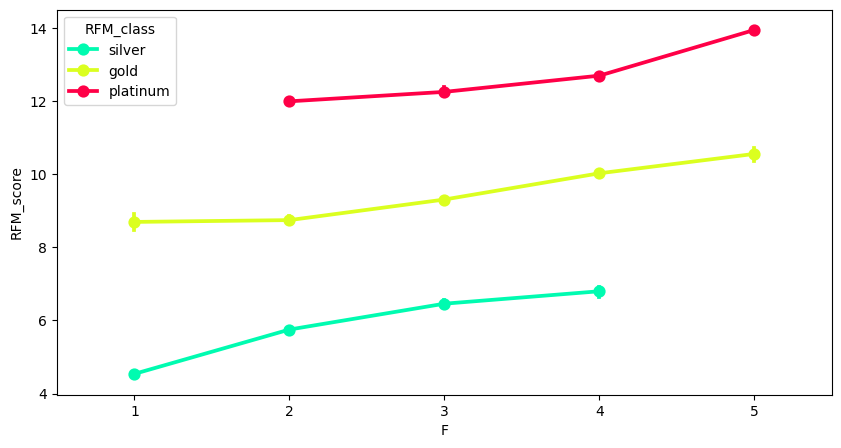

In [48]:
# pointplot, Frequency부분 RFM_score
plt.figure(figsize=(10,5))
sns.pointplot(data=rfm, x='F', hue='RFM_class', y='RFM_score', palette='gist_ncar')

<Axes: xlabel='M', ylabel='RFM_score'>

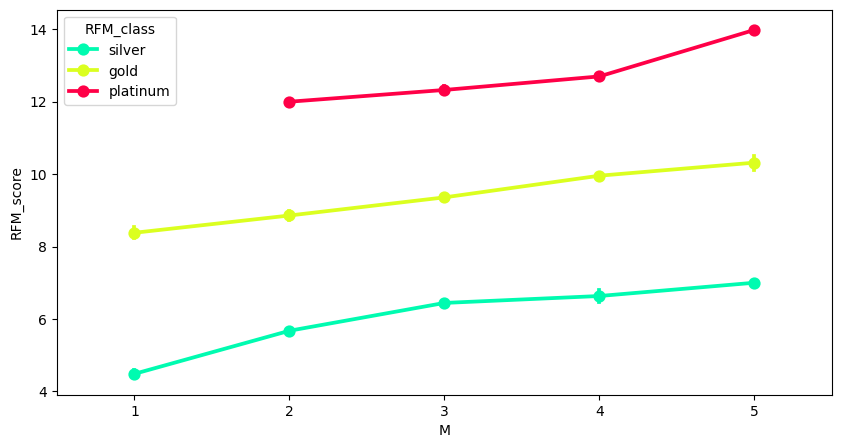

In [55]:
# pointplot, MonetaryValue부분 RFM_score
plt.figure(figsize=(10,5))
sns.pointplot(data=rfm, x='M', hue='RFM_class', y='RFM_score', palette='gist_ncar')

In [56]:
# RFM_class 별 그룹화
# 'Recency','Frequency' 평균을 구함
# 'MonetaryValue' 는 'sum', 'mean', 'count'
rfm.groupby('RFM_class').agg({'Recency':'mean',
                             'Frequency':'mean',
                             'MonetaryValue':['sum','mean','count']}).style.background_gradient('Blues').format("{:,.0f}")

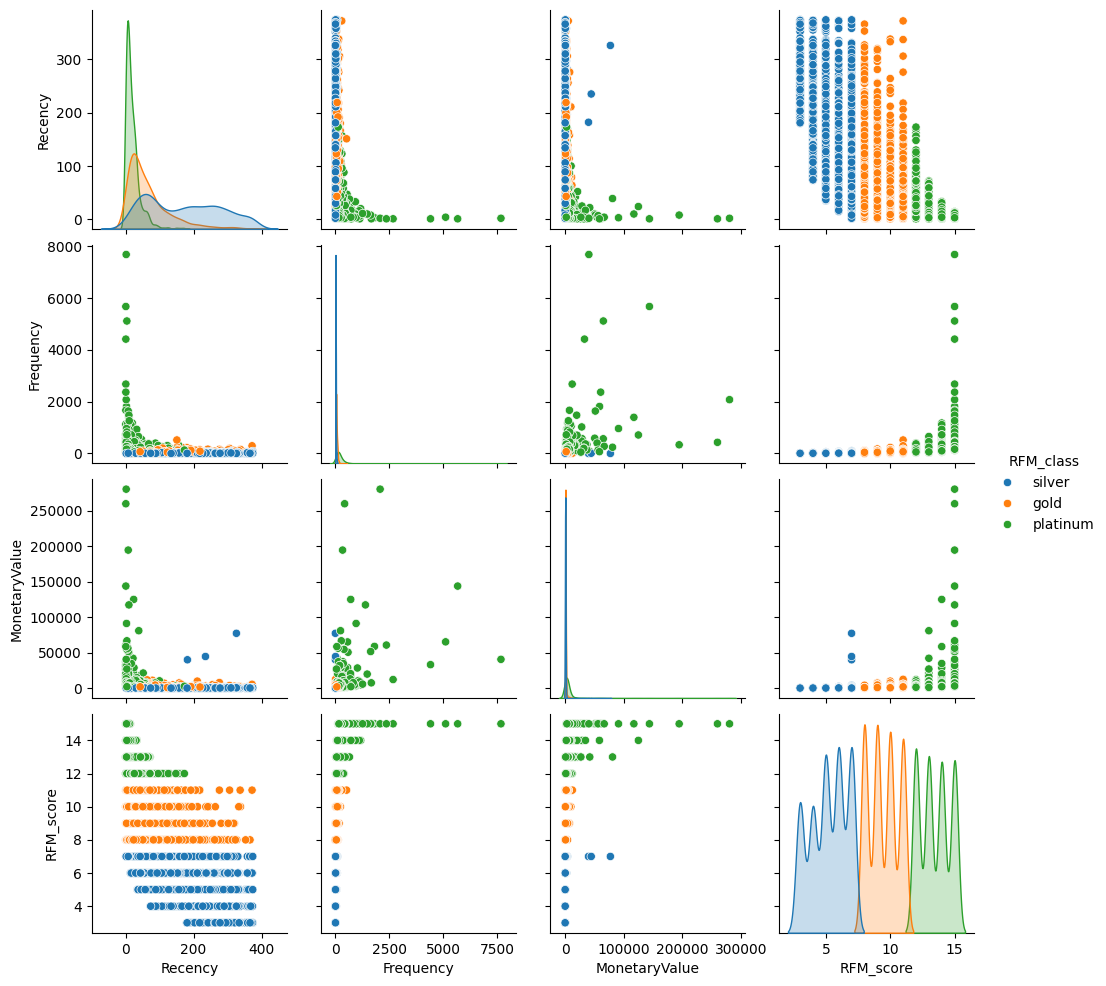

In [57]:
# Pairplot
sns.pairplot(rfm, hue='RFM_class')

In [58]:
# 변수간 상관관계 확인(선형적 관계)
# .corr()
# 1에 가까울수록 양의 상관관계, -1에 가까울수록 음의 상관관계
corr = rfm.select_dtypes(include='number').corr()
corr

,Recency,Frequency,MonetaryValue,RFM_score
Recency,1.000000,-0.206618,-0.122937,-0.700621
Frequency,-0.206618,1.000000,0.444920,0.404260
MonetaryValue,-0.122937,0.444920,1.000000,0.250433
RFM_score,-0.700621,0.404260,0.250433,1.000000


<Axes: >

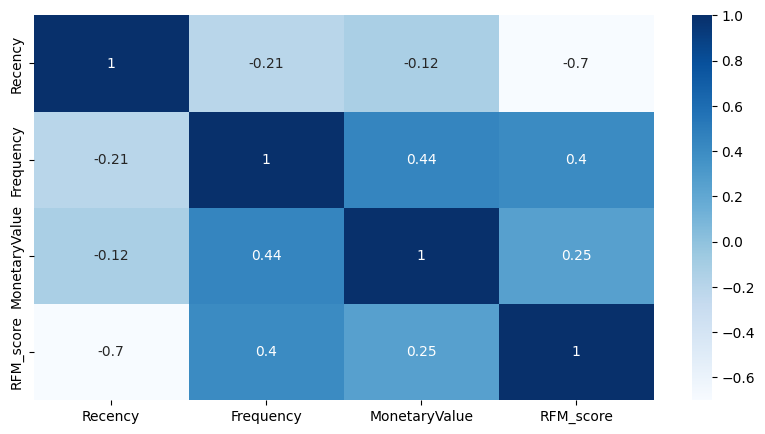

In [59]:
# 시각화
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, cmap='Blues')

<Axes: >

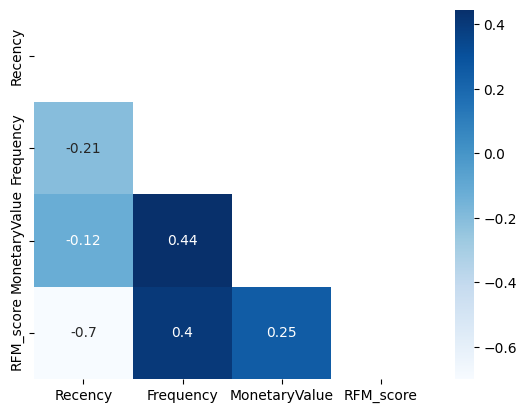

In [60]:
# 삼각형 마스크
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap='Blues', mask=mask)

Rececy 인 경우 최근일수록 점수가 더 높기 때문에 음의 상관관계를 가지고 나머지는 양의 상관관계를 가지고 있다.

***RFM의 목적은 고객들이 어느 한 곳으로 몰려있거나 한 눈에 고객층이 어떻게 이루어져있는지 알기 힘들 때 같은 간격으로 구간(Segement)를 나누어 좀 더 쉽게 알 수 있게 만드는 역할에 있다.***

In [61]:
# csv 저장
# rfm.to_csv('rfm.csv')